In [1]:
import bottleneck as bn
import dask
import folium
import holoviews as hv
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
import yaml
import zarr
import gc
import os
import rioxarray

from tqdm import tqdm
from ascat.read_native.ragged_array_ts import CellFileCollection
from collections import defaultdict
from dask.distributed import Client
from odc import stac as odc_stac
import odc.stac
from pathlib import Path
from pyproj import Transformer
from scipy.spatial import cKDTree
import warnings
from collections import defaultdict

import requests
! pip install geopandas
import geopandas as gpd

import tempfile
import zipfile
import io

In [37]:
client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="512GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.131.72.105:8787/status,
Dashboard: http://128.131.72.105:8787/status,Workers: 3
Total threads: 6,Total memory: 1.40 TiB
Status: running,Using processes: False
Comm: inproc://128.131.72.105/4072784/1,Workers: 3
Dashboard: http://128.131.72.105:8787/status,Total threads: 6
Started: Just now,Total memory: 1.40 TiB
Comm: inproc://128.131.72.105/4072784/4,Total threads: 2
Dashboard: http://128.131.72.105:41233/status,Memory: 476.84 GiB
Nanny: None,


Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V0M2R4/EQUI7_AF020M/E030N090T3/SIG0_20220106T182621__VV_A147_E030N090T3_AF020M_V0M2R4_S1AIWGRDH_TUWIEN.tif:1
2025-06-17 16:03:33,924 - distributed.worker - WARNING - Compute Failed
Key:       ('VV-truediv-getitem-5bac0e776f03e624502638179b4ff620', 1, 0, 0)
Function:  execute_task
args:      ((<function getitem at 0x7f4cdfa2c1f0>, (<function getitem at 0x7f4cdfa2c1f0>, (subgraph_callable-5fb36bdc-027d-45da-8de6-e2ea5a0d5c96, 10, array(nan, dtype=float32), (<function _dask_loader_tyx at 0x7f4cdcc45240>, [[<odc.loader._rio.RioReader object at 0x7f4cc8340970>]], Tiles: 1x1|15_000x15_000px => 15_000x15_000px, (0, 0), (), (), RasterLoadParams(dtype='int16', fill_value=-9999, src_nodata_fallback=None, src_nodata_override=None, use_overviews=True, resampling='nearest', fail_on_error=True, dims=()), <odc.loader._rio.RioDriver object at 0x7f4cc8503130>, {'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR', 'G

## Loading Sentinel - 1 Sigma Naught Data from EODC STAC Catalogue

In [ ]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

collection_id = "SENTINEL1_SIG0_20M"

collection = eodc_catalog.get_collection(collection_id)

### Area of Intesest

In [ ]:
# Area for testing the code (selected area so e.g. the ffill is visible)
"""
time_range ="2022-01-06/2022-01-07" 

latmin, latmax = 44, 45         # South to North
lonmin, lonmax = 7, 8           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

'\ntime_range ="2022-01-06/2022-01-07" \n\nlatmin, latmax = 44, 45         # South to North\nlonmin, lonmax = 7, 8           # West to East\n\nbounding_box = [lonmin, latmin, lonmax, latmax]\n#'

In [ ]:
# Europe Africa Intersection
"""
time_range ="2022-01-01/2022-02-01"

latmin, latmax = 35, 37            # South to North
lonmin, lonmax = -6, -5           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [ ]:
# Whole Spatial Area but...
#"""
#time_range ="2022-01-06T18:28:01.000000000" # one image
time_range = "2022-01-06/2022-01-06"  # one month

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

'\n#time_range ="2022-01-06T18:28:01.000000000" # one image\ntime_range = "2022-01-06/2022-01-06"  # one day\n\nlatmin, latmax = 30.0, 45.0            # South to North\nlonmin, lonmax = -10.0, 5.0            # West to East\n\nbounding_box = [lonmin, latmin, lonmax, latmax]\n#'

In [ ]:
# Area and Time of Interest
# This will not finish on your local pc
# Try to run in on a large Cluster
"""
time_range = "2021-01-01/2023-12-31"

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

#append to zar monthly ffill?
#"""

'\ntime_range = "2021-01-01/2023-12-31"\n\nlatmin, latmax = 30.0, 45.0            # South to North\nlonmin, lonmax = -10.0, 5.0            # West to East\n\nbounding_box = [lonmin, latmin, lonmax, latmax]\n\n#append to zar monthly ffill?\n#'

### Stack Request

In [ ]:
search = eodc_catalog.search(
    collections=collection_id,
    bbox=bounding_box,
    datetime=time_range,
    #max_items=1  # number of max items to load
)
items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 11 items for the given search query


### Mapping Images to Tiles in Europe and Africa

Information on the Equi7 grid: https://cartography.tuwien.ac.at/eurocarto/wp-content/uploads/2015/09/3_6_ppt.pdf

In [ ]:
# Split into European and African Equi7 projections

items_crs_europe = []
items_crs_africa = []

for item in items_eodc:
    wkt = item.properties["proj:wkt2"]
    lat_center = float(wkt.split('PARAMETER["latitude_of_center",')[1].split(']')[0])  # we select based on the latitude of the center of the projection

    if lat_center == 53.0:
        items_crs_europe.append(item)
    elif lat_center == 8.5:
        items_crs_africa.append(item)

print(f"Equi7 Europe (lat 53.0): {len(items_crs_europe)} items")
print(f"Equi7 Africa (lat 8.5): {len(items_crs_africa)} items")

Equi7 Europe (lat 53.0): 5 items
Equi7 Africa (lat 8.5): 6 items


In [ ]:
# Make groups for each tile

def extract_tile_id_from_name(item_id):
    parts = item_id.split("_")
    tile_id = parts[3]
    if len(tile_id) == 10:
            return tile_id

european_tiles = defaultdict(list)
african_tiles = defaultdict(list)

for item in items_crs_europe:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in european_tiles[tile_id]:
        european_tiles[tile_id].append(item)

for item in items_crs_africa:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in african_tiles[tile_id]:
        african_tiles[tile_id].append(item)

print(f"European tiles: {len(european_tiles)}")
print(f"African tiles: {len(african_tiles)}")
european_tiles

European tiles: 1
African tiles: 1


defaultdict(list,
            {'E030N006T3': [<Item id=SIG0_20220107T062753_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062728_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062703_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220106T182646_A147_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220106T182621_A147_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>]})

### Selecting the T3 files

As we do not want to load all the files we select the ones that are interesting for our analysis

<img src="..\images\Tiles_Europe.jpeg" alt="Tiles of Europe" width="400">
<img src="..\images\Tiles_Africa.jpeg" alt="Tiles of Europe" width="400">


In [28]:
# Selecting 14 European tiles
european_target_tiles = {
    "E027N009T3", 
    "E030N006T3", "E030N009T3", "E030N012T3", "E030N015T3", 
    "E033N006T3", "E033N009T3", "E033N012T3", "E033N015T3", 
    "E036N006T3", "E036N009T3", "E036N012T3",
    "E039N009T3", "E039N012T3" 
}

european_tiles = {
    tile_id: items
    for tile_id, items in european_tiles.items()
    if tile_id in european_target_tiles
}

# Selecting 6 African Tiles
african_target_tiles = {
    "E030N090T3", "E030N087T3",
    "E033N090T3", "E033N087T3", 
    "E036N090T3", "E036N087T3", 
}

african_tiles = {
    tile_id: items
    for tile_id, items in african_tiles.items()
    if tile_id in african_target_tiles
}

print(f"European tiles: {len(european_tiles)}")
print(f"African tiles: {len(african_tiles)}")

European tiles: 1
African tiles: 1


### Plothing Thumbnail of the data

In [ ]:
# Showing thumbnail image of the data
#"""
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

for item in european_tiles['E030N006T3']:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets["thumbnail"].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    ).add_to(map)

folium.LayerControl().add_to(map)

map
#"""

### Loading Shapefiles

In [ ]:
# Europe:

url = "https://sdi.eea.europa.eu/webdav/datastore/public/eea_r_3035_1_km_leac-clc2012-mask_p_2016_v01_r00/eea_r_3035_1_km_LEAC_mask.tif"

resp = requests.get(url)

tmp = tempfile.NamedTemporaryFile(suffix=".tif", delete=False) # Save to temp file
with open(tmp.name, "wb") as f:
    f.write(resp.content)

mask_europe = rioxarray.open_rasterio(tmp.name, masked=True).squeeze(drop=True)
mask_europe

<xarray.DataArray (y: 4475, x: 6374)> Size: 114MB
[28523650 values with dtype=float32]
Coordinates:
  * x            (x) float64 51kB 9.435e+05 9.445e+05 ... 7.316e+06 7.316e+06
  * y            (y) float64 36kB 5.416e+06 5.414e+06 ... 9.425e+05 9.415e+05
    spatial_ref  int32 4B 0
Attributes:
    DataType:         Generic
    AREA_OR_POINT:    Area
    SourceBandIndex:  0
    scale_factor:     1.0
    add_offset:       0.0

In [ ]:
# the african mask does not fit properly


from affine import Affine
from rasterio.features import rasterize

# Africa:

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

resp = requests.get(url)

with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    folder = "ne_admin0_africa"
    z.extractall(folder)

shp_path = os.path.join(folder, "ne_110m_admin_0_countries.shp")
gdf = gpd.read_file(shp_path)

mask_africa_df = gdf[gdf["CONTINENT"] == "Africa"].to_crs("EPSG:3035")


# --- Define resolution and bounds ---
res = 1000  # 1 km
minx, miny, maxx, maxy = mask_africa_df.total_bounds

width = int((maxx - minx) // res)
height = int((maxy - miny) // res)

transform = Affine.translation(minx, maxy) * Affine.scale(res, -res)

# --- Rasterize the Africa polygon ---
raster = rasterize(
    [(geom, 1) for geom in mask_africa_df.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# --- Construct xarray DataArray ---
x = np.arange(width) * res + minx + res / 2
y = maxy - (np.arange(height) * res + res / 2)

mask_africa = xr.DataArray(
    raster,
    dims=("y", "x"),
    coords={"y": y, "x": x},
    name="africa_mask"
)

# --- Save as GeoTIFF ---
mask_africa.rio.write_crs("EPSG:3035", inplace=True)
mask_africa.rio.to_raster("africa_mask_1km.tif")
mask_africa

<xarray.DataArray 'africa_mask' (y: 7059, x: 8131)> Size: 57MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y            (y) float64 56kB 1.586e+06 1.585e+06 ... -5.471e+06 -5.472e+06
  * x            (x) float64 65kB 1.246e+06 1.247e+06 ... 9.375e+06 9.376e+06
    spatial_ref  int32 4B 0

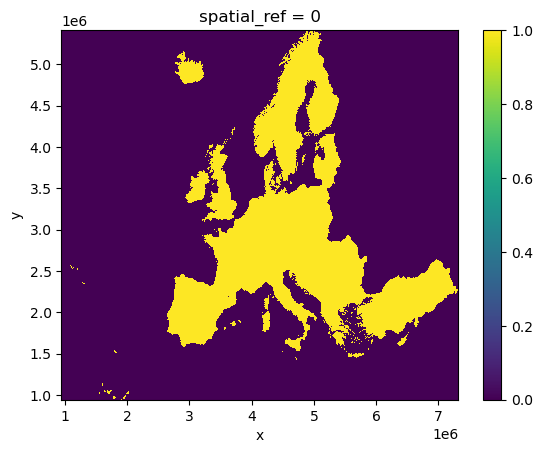

KeyboardInterrupt: 

In [26]:
mask_europe.plot.imshow()
plt.show()
mask_africa.plot.imshow()
plt.show()

# Run code tile-by-tile

In [ ]:
def process_tile(tile_id, tiles_dict, crs, output_dir, items_eodc, mask):
    res = 20
    chunks = {"time": 1, "y": 15000, "x": 1000}
    try:
        sig0_dc = odc_stac.load(
            tiles_dict[tile_id],
            crs=crs,
            resolution=res,
            chunks=chunks,
            resampling="bilinear",                         # not good for dB data?! -> nearest would be better
        )

        nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
        scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

        sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

        mask_aligned = mask.rio.reproject_match(sig0_dc)
        sig0_dc = sig0_dc.where(mask_aligned == 1, drop=True)

        sig0_dc_linear = 10 ** (sig0_dc / 10)

        sig0_dc_linear_hourly = sig0_dc_linear.resample(time="1h").mean(dim="time").persist()
        sig0_dc_linear_hourly = sig0_dc_linear_hourly.dropna(dim="time", how="all")
        sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=312, y=312, boundary="pad").mean()
        sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")
        
        sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled)

        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{tile_id}.zarr")
        sig_dc_6km.to_zarr(output_path, mode="w")
        print(f"Processed and saved: {output_path}")

        # Clean up memory
        del sig0_dc, sig0_dc_linear, sig0_dc_linear_hourly, sig0_dc_linear_6km, sig_dc_linear_6km_filled, sig_dc_6km
        gc.collect()

    except Exception as e:
        print(f"Error processing tile {tile_id}: {e}")


## Processing European Tiles

In [ ]:
for tile_id, items_list in tqdm(european_tiles.items(), desc="Processing European Tiles"):
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        process_tile(
            tile_id=tile_id,
            tiles_dict=european_tiles,
            crs="EPSG:27704",  # Europe CRS
            output_dir="../data/Sentinel-1/Europe",
            items_eodc=items_list,
            mask=mask_europe
        )

## Processing African Tiles

In [ ]:
for tile_id, items_list in tqdm(african_tiles.items(), desc="Processing African Tiles"):
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        process_tile(
            tile_id=tile_id,
            tiles_dict=african_tiles,
            crs="EPSG:27701",  # Africa CRS
            output_dir="../data/Sentinel-1/Africa",
            items_eodc=items_list,
            mask= mask_africa
        )


# Testing
Here tiles are manually loaded and the processing is tested: 

In [ ]:
crs = "EPSG:27704" # Europe
#crs = "EPSG:27701" # Africa

chunks = {"time": 1, "y": 15000, "x": 15000}
sig0_dc = odc_stac.load(
    european_tiles['E036N006T3'],
    #african_tiles['E030N090T3'],
    resolution=20, # errror if not set
    crs=crs,                                       
    chunks=chunks,
)

nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

# masking the data
#mask_africa_aligned = mask_africa.rio.reproject_match(sig0_dc) # match CRS and resolution
#sig0_dc = sig0_dc.where(mask_africa_aligned == 1, drop=True)

mask_europe_aligned = mask_europe.rio.reproject_match(sig0_dc) # match CRS and resolution
sig0_dc = sig0_dc.where(mask_europe_aligned == 1, drop=True)

sig0_dc

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 5, y: 7908, x: 7983)
Coordinates:
  * y        (y) float64 63kB 9e+05 9e+05 9e+05 ... 7.256e+05 7.256e+05
  * x        (x) float64 64kB 3.14e+06 3.14e+06 3.14e+06 ... 3.3e+06 3.3e+06
  * time     (time) datetime64[ns] 40B 2022-01-06T18:26:21 ... 2022-01-07T06:...
Data variables:
    VH       (time, y, x) float32 1GB dask.array<chunksize=(1, 7908, 7983), meta=np.ndarray>
    VV       (time, y, x) float32 1GB dask.array<chunksize=(1, 7908, 7983), meta=np.ndarray>

## Processing

In [ ]:
# Transform to linear scale to do calculations 
sig0_dc_linear = 10 ** (sig0_dc / 10)

# Merge in time direction 
sig0_dc_linear.coords['time'] = sig0_dc_linear.time.dt.ceil('1h')
sig0_dc_linear_hourly = sig0_dc_linear.groupby('time').mean(skipna=True)

# Lower the resolution from 20m to 6km  
sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=300, y=300, boundary='pad').mean() # 15000/300 = 50 pixels in x and y direction (for masked data this is smaller)

# ffill values 
sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")

# Convert back to dB
sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled)

In [13]:
sig_dc_6km.to_zarr("output_6km_filled.zarr", mode="w") 


### Appending to Zarr

Here the problem is that all three dimmensions are not matching (at least one needs to):

- x
- y
- time

so we can not to the append to zarr. We will now try to load them all into a separate file and do the ASCAT-Sentinel merge for every tile instead.

In [ ]:
# x_vals = sig_dc_6km.coords["x"].values
# y_vals = sig_dc_6km.coords["y"].values

# x_min, x_max = x_vals.min(), x_vals.max()
# y_min, y_max = y_vals.min(), y_vals.max()
# print(f'"x": slice({x_min}, {x_max})')
# print(f'"y": slice({y_min}, {y_max})')

# append to zarr
# sig_dc_6km.to_zarr("output_6km_filled.zarr",mode="r+", region = {'x': slice(x_min, x_max), 'y': slice(y_min, y_max)})

### Plotting vor Verification
Some plotting to verify if the code produces the intended output

In [16]:
# Show steps visually:
""" only run if in testing mode

sig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)
plt.show()

sig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()
#"""

' only run if in testing mode\n\nsig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)\nplt.show()\n\nsig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n\nsig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n\nsig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n#'